# Custom aleotoric epistemic training head

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import fastai.basic_train

In [15]:
#this needs to be replaced
def _loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None,num_sim =1)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    #bllbacks on loss most likley wont work with this, so be careful
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    
    if num_sim > 1:
        assert model.training == True
        output_simulations = [model(*xb) for _ in range(num_sim)]
    elif num_sim == 1:
        output_simulations = model(*xb)
        
        
    #out = model(*xb)
    #out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), to_detach(yb[0])
    
    output_components = model.get_preds(output_simulations)
    p_mean, epistemic, aleatoric = output_components
    model.aleatoric.append(aleatoric.detach().cpu())
    if num_sim > 1:
        model.epistemic.append(epistemic.detach().cpu())
    loss = loss_func(p_mean, *yb)

    if opt is not None:
        loss,skip_bwd = cb_handler.on_backward_begin(loss)
        if not skip_bwd:                     loss.backward()
        if not cb_handler.on_backward_end(): opt.step()
        if not cb_handler.on_step_end():     opt.zero_grad()

    return loss.detach().cpu()

In [16]:
fastai.basic_train.loss_batch = _loss_batch

In [28]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image

from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
import torch.distributions as tdist
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [6]:
#some Utils
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat


def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
            
            
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [18]:
import warnings

warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')

## Data

In [9]:
#WORKING_DIR = Path('/home/kaiah_steven_maxkelsen_com/glaucoma')
WORKING_DIR = Path('/home/jovyan/glaucoma/')
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR / 'training'
CLEAN_DIR = DATA_DIR / "train_clean"

In [10]:
path_img = CLEAN_DIR


In [11]:
#using smaller image size
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(400,520) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [26]:
def create_head_split(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [23]:
learn = cnn_learner(data,models.resnet34)

In [19]:
learn.model[1][-1].in_features

512

In [24]:
combined_res = combined_model(learn.model[0],learn.model[1],1)

Epistemic not possible when num_sim = 1


In [25]:
learn.destroy()
learn = Learner(data,combined_res)

this Learner object self-destroyed - it still exists, but no longer usable


In [33]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


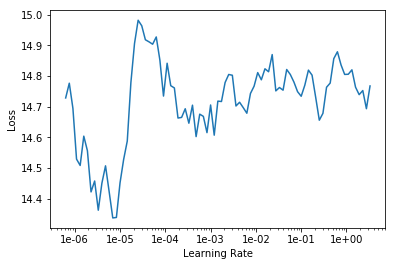

In [34]:
learn.recorder.plot()

In [26]:
learn.data.batch_size= 32


In [ ]:
lr = 4e-02
learn.fit_one_cycle(2,lr )

epoch,train_loss,valid_loss,time
0,156558405147861975040.000000,81610906974289920.000000,27:24


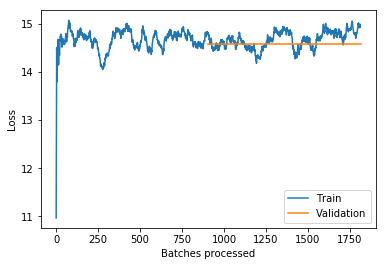

In [45]:
learn.recorder.plot_losses()

In [69]:
al = [ np.mean(i.detach().cpu().numpy()) for i in learn.model.aleatoric]
ep = [ np.mean(i.detach().cpu().numpy()) for i in learn.model.epistemic]

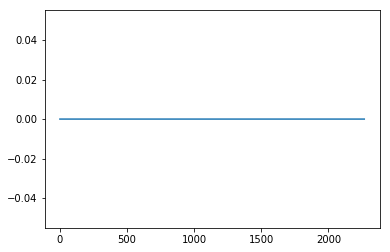

In [70]:
plt.plot(ep)

In [72]:
def heteroscedastic_loss(preds, target, log_var, br):
    """
    As per Kendall and Gal (2017).
    """
    return torch.mean(torch.sum(torch.exp(-log_var) * (target-preds)**2 + log_var), 0)

In [13]:
class combined_model(nn.Module):
    def __init__(self,arch, head, num_sim):
        super().__init__()
        self.output_mean = torch.nn.Linear(learn.model[1][-1].in_features,learn.model[1][-1].out_features)
        self.output_lstd = torch.nn.Linear(learn.model[1][-1].in_features,learn.model[1][-1].out_features)
        self.model =[arch,head[:-1]]
        self.num_sim = num_sim
        self.uncertainty_method = "variance"
        self.aleatoric = []
        self.epistemic = []
        
        if self.num_sim == 1:
            # Change to logging
            print("Epistemic not possible when num_sim = 1")
    
    def forward(self, inp):
        x = self.model[0](inp)
        x = self.model[1](x)
        x_mean = self.output_mean(x)
        x_lstd = self.output_lstd(x)
        return x_mean, x_lstd
    
    def get_preds(self, output_simulations, ignore_uncertainty=False):
        """
        Should be the same for all subclasses except CMCD.
        """
        if self.num_sim > 1:
            mean, log_std = (torch.stack(o) for o in (zip(*output_simulations)))
        elif self.num_sim == 1:
            mean, log_std = output_simulations
        else:
            raise Exception("nah gammon")
        
        # sample from logit space to allow for noise attenuation
        u = self.sample_logit_space(mean, log_std)
        
        #log_p = F.log_softmax(u, dim=-1)
    
        
        #if self.num_sim > 1:
        #    log_p = torch.mean(log_p, dim=0)
        
        if self.num_sim > 1:
            u_mean = torch.mean(u, dim=0)
        else:
            u_mean = u
            
        if ignore_uncertainty:
            return log_p
        
        # determine uncertainty
        epistemic = self.get_epistemic(u)
        aleatoric = self.get_aleatoric(log_std)
        
        #return log_p, epistemic, aleatoric
        return u_mean,epistemic, aleatoric
    
    def sample_logit_space(self, mean, log_std):
        """
        Helper function. As per Kendal and Gal (2017).
        """
        epsilon = tdist.Normal(torch.zeros_like(mean), torch.ones_like(log_std)).sample()
        u = mean + epsilon * torch.exp(log_std)
        return u
        
    def get_epistemic(self, u):
        """
        Note we repeate softmax calc here becasue we want softmax, not log_softmax...
        
        As per Kendal and Gal (2017), we here take entropy of the softmax as uncertainty.
        For the Bayesian extension, we parse the distribution through the softmax, take 
        the expectation, then, finally, calculate the entropy.
        """
        if self.uncertainty_method == "variance":
            if self.num_sim > 1:
                return torch.var(u,dim = 0)
            else:
                return 0
            
        elif self.uncertainty_method == "information-theoretic":
            p = F.softmax(u, dim=-1)
            # expectation would be here if this were bayes.
            return self.get_entropy(p)
        
    def get_aleatoric(self, lstd): 
        """
        basically just allows me to not duplicate code below... 
        See subclass for actual implementation.
        """
        # alternative would be to output the variance corresponding to max p_i
        
        
        return torch.mean(torch.square(torch.exp(lstd)), dim=-1)
        
    def get_entropy(self, P):
        """
        @requires: shape of P to be batch_size X dim_out 
        @returns: vector of size = self.batch_size
        
        Helper function. A way in which uncertainty about a classification inference
        may be estimated.
        """
        return - torch.sum(P * torch.log(P), dim=-1)
        